## Import

In [81]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device='cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

In [82]:
train_data=datasets.FashionMNIST(
    root='Data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)
test_data=datasets.FashionMNIST(
    root='Data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

### Know your Data

In [83]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [84]:
# image,label=train_data #(image_tensor,label)
train_data[58000] #(image_tensor,label)
train_data[58000][0] #(image_tensor,label)[0] --> image_tensor
train_data[58000][1] #(image_tensor,label)[1] --> label


3

In [85]:
classes=train_data.classes
classes


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Data Loader


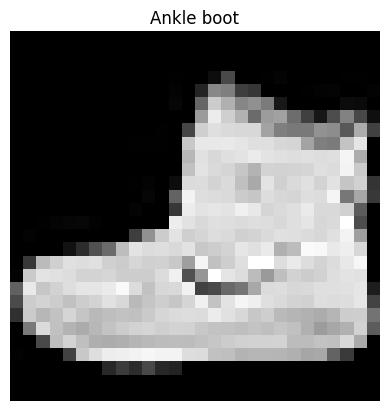

In [86]:
plt.imshow(train_data[0][0].view(28,28))
plt.imshow(train_data[0][0].numpy().squeeze(),cmap='gray')
plt.title(classes[train_data[0][1]])
plt.axis(False);


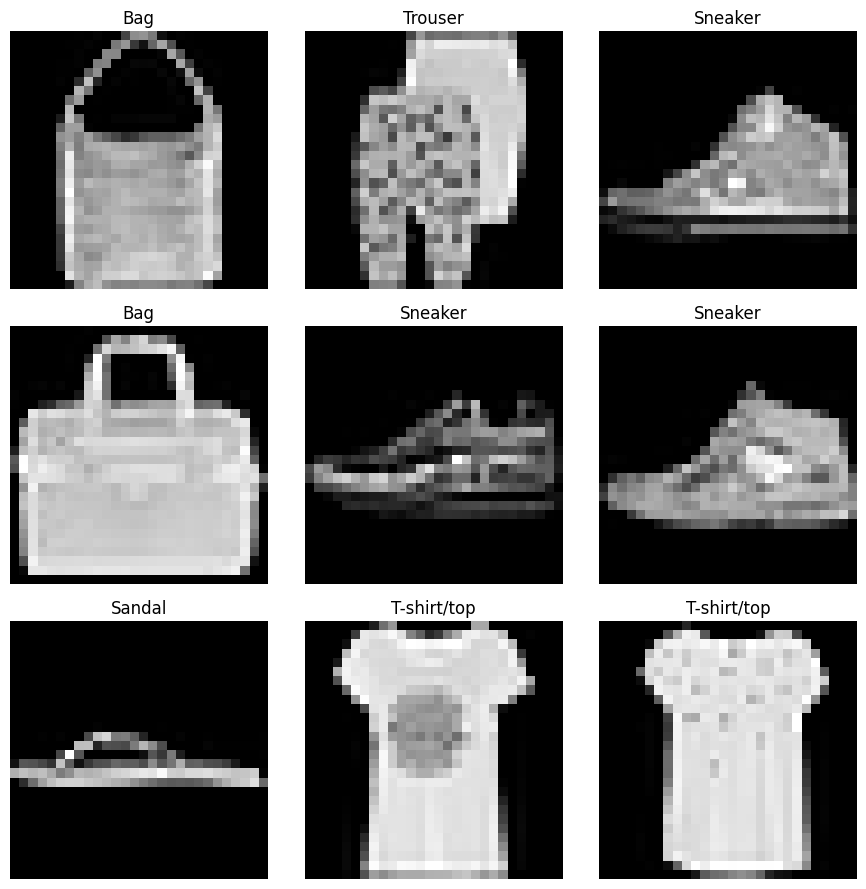

In [87]:
nrows=3
ncols=3
fig=plt.figure(figsize=(9,9))
for i in range(1,nrows*ncols+1):
    fig.add_subplot(nrows,ncols,i)
    random_index=torch.randint(low=0,high=len(train_data),size=(1,)).item()
    image,label=train_data[random_index]
    plt.imshow(image.numpy().squeeze(),cmap='gray')
    plt.title(classes[label])
    plt.axis(False)
plt.tight_layout()



## DataLoader

In [88]:
from torch.utils.data import DataLoader

In [89]:
BATCH_SIZE=32
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)
print(f"Size of Train DataLoader: {len(train_dataloader)}")
print(f"Size of Test DataLoader: {len(test_dataloader)}")

Size of Train DataLoader: 1875
Size of Test DataLoader: 313


In [90]:
train_image_batch,train_label_batch=next(iter(train_dataloader))
train_image_batch.shape,train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Model 0 : A baseline model
Going with Linear

In [91]:
sample=torch.rand_like(train_data[0][0])


flatten_model=nn.Flatten()
output=flatten_model(sample)

print(f"Sample Shape: {sample.shape}")
print(f"Output Shape: {output.shape}")

Sample Shape: torch.Size([1, 28, 28])
Output Shape: torch.Size([1, 784])


In [92]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_features:int,hidden_nuerons:int,output_features:int):
        super().__init__()
        self.layer_seq=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features,out_features=hidden_nuerons),
            nn.Linear(in_features=hidden_nuerons,out_features=output_features)
        )
    def forward(self,x):
        return self.layer_seq(x)

In [93]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [94]:
model_0=FashionMNISTModelV0(input_features=torch.flatten(sample).shape[0],
                           hidden_nuerons=10,
                           output_features=len(classes)).to(device=device)
model_0


FashionMNISTModelV0(
  (layer_seq): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Testing model_0

In [95]:
sample_logits=model_0(sample)
print(f"Sample Logits: {sample_logits}")

sample_pred=torch.softmax(sample_logits,dim=1).argmax(dim=1)
print(f"Sample Prediction: {sample_pred}")


Sample Logits: tensor([[-0.0838,  0.0399, -0.3167,  0.1801, -0.2034,  0.0404, -0.1264, -0.1921,
          0.1502,  0.0252]], grad_fn=<AddmmBackward0>)
Sample Prediction: tensor([3])


## Loss and optimizer

In [96]:
loss_fn=nn.CrossEntropyLoss()
optim=torch.optim.SGD(params=model_0.parameters(),
                      lr=0.1)

### Take Function from github file

In [97]:
import requests
from pathlib import Path
FILE_PATH="utils//helper_functions.py"
if Path(FILE_PATH).is_file():
    print(f"File exist: {FILE_PATH}")
else:
    print(f"Downloading File {FILE_PATH}")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open(FILE_PATH,'wb') as f:
        f.write(request.content)

File exist: utils//helper_functions.py


### Define Accuracy


In [98]:
def accuracy_fn(y_true,y_pred):
    total_samples=len(y_pred)
    correct=(y_true==y_pred).sum().item()
    return round((correct/total_samples)*100,2)

### Time function for model timing

In [99]:
from timeit import default_timer as timer

In [100]:
def total_time_taken(start_time:float,end_time:float,device:torch.device):
    total_time=end_time-start_time
    print(f"Total time Taken on {device} : {total_time:.3f} secs")
    return total_time

## Training Loop

In [101]:
from tqdm.auto import tqdm

In [102]:
# epoch_count=[]
# train_loss_list=[]
# test_loss_list=[]
# epochs=3

# training_start_time=timer()

# for epoch in tqdm(range(epochs)):
#     epoch_count.append(epoch)
#     batch_train_loss=0
#     batch_train_accuracy=0
#     for batch,(X,y) in enumerate(train_dataloader):
#         model_0.train()
        
#         y_logits=model_0(X)
#         y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

#         loss=loss_fn(y_logits,y)
#         batch_train_loss+=loss
#         batch_train_accuracy+=accuracy_fn(y,y_pred)

#         optim.zero_grad()

#         loss.backward()

#         optim.step()

#         # if batch%400==0:
#         #     print(f"{batch} Done")

#     train_loss=batch_train_loss/len(train_dataloader)
#     train_acc=batch_train_accuracy/len(train_dataloader)
#     train_loss_list.append(train_loss.detach().numpy())

#     #Testing
#     batch_test_loss,batch_test_accuracy=0,0
    
#     model_0.eval()

#     with torch.inference_mode():
#         for batch,(X,y) in enumerate(test_dataloader):
#             y_test_logits=model_0(X)
#             y_test_pred=torch.softmax(y_test_logits,dim=1).argmax(dim=1)

#             batch_test_loss+=loss_fn(y_test_logits,y)
#             batch_test_accuracy+=accuracy_fn(y,y_test_pred)

#         test_loss=batch_test_loss/len(test_dataloader)
#         test_acc=batch_test_accuracy/len(test_dataloader)
#         test_loss_list.append(test_loss.detach().numpy())
        
#     print(f"{epoch}: Train Loss: {train_loss} | Train Accuracy: {train_acc} | Test Loss: {test_loss} | Test Accuracy: {test_acc}")

# training_end_time=timer()

# total_time_taken(training_start_time,training_end_time,device=device)

# plt.plot(epoch_count,train_loss_list,c='red',label='Training loss')
# plt.plot(epoch_count,test_loss_list,c='green',label='Testing loss')
# plt.title(label='Training vs Testing Loss')
# plt.legend()
        

                

## Model 1
Could added non-linear layer

## Model 2
CNN

In [103]:
sample.flatten().shape[0]

784

In [104]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self,color_channel,hidden_nuerons,output_features):
        super().__init__()
        self.kernel_size=3
        self.block_1=nn.Sequential(
            nn.Conv2d(in_channels=color_channel,
                      out_channels=hidden_nuerons,
                      stride=1,
                      padding=self.kernel_size//2,
                      kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nuerons,
                      out_channels=hidden_nuerons,
                      stride=1,
                      padding=self.kernel_size//2,
                      kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_nuerons,
                      out_channels=hidden_nuerons,
                      stride=1,
                      padding=self.kernel_size//2,
                      kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nuerons,
                      out_channels=hidden_nuerons,
                      stride=1,
                      padding=self.kernel_size//2,
                      kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_nuerons*7*7,
                      out_features=output_features)
        )
    def forward(self,x):
        x=self.block_1(x)
        x=self.block_2(x)
        x=self.classifer(x)
        return x
color_channels=1
hidden_nuerons=10
output_features=len(classes)
model_2=FashionMNISTModelV2(color_channel=color_channels,
                            hidden_nuerons=hidden_nuerons,
                            output_features=output_features).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Let us Test each layer and its output

### Conv2d

In [105]:
# Data
sample_data=torch.randn(size=[32,3,28,28],device=device)
sample_data[0].shape

torch.Size([3, 28, 28])

In [106]:
test_Conv2d=nn.Conv2d(in_channels=3,
                      out_channels=10,
                      padding=1,
                      stride=1,
                      kernel_size=3)

In [107]:
test_Conv2d(sample_data).shape

torch.Size([32, 10, 28, 28])

In [108]:
test_Conv2d.weight.shape

torch.Size([10, 3, 3, 3])

In [109]:
test_Conv2d.bias.shape

torch.Size([10])

In [110]:
### Maxpoollayer
test_maxpool=nn.MaxPool2d(kernel_size=2,
                          stride=2)

print(test_maxpool(sample_data).shape)

torch.Size([32, 3, 14, 14])


## Loss and Optimizer Setup

In [111]:
## Loss and Optimizer Setup
loss_fn=nn.CrossEntropyLoss()
optim=torch.optim.SGD(params=model_2.parameters(),
                      lr=0.1)

In [112]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

In [113]:
train_start_time=timer()

epoch_count=[]
train_loss_list=[]
test_loss_list=[]
epochs=3

for epoch in tqdm(range(epochs)):
    batch_train_loss=0
    batch_train_accuracy=0
    epoch_count.append(epoch)

    for batch,(X,y) in enumerate(train_dataloader):
        model_2.train()
        y_logits=model_2(X)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        loss=loss_fn(y_logits,y)
        batch_train_loss+=loss
        batch_train_accuracy+=accuracy_fn(y,y_pred)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if batch%400==0:
            print(f"{batch} Done")

    train_loss=batch_train_loss/len(train_dataloader)
    train_acc=batch_train_accuracy/len(train_dataloader)
    train_loss_list.append(train_loss.detach().numpy())

    batch_test_loss=0
    batch_test_accuracy=0

    with torch.inference_mode():
        model_2.eval()
        for batch,(X,y) in enumerate(test_dataloader):
            y_test_logits=model_2(X)
            y_test_pred=torch.softmax(y_test_logits,dim=1).argmax(dim=1)
            loss=loss_fn(y_test_logits,y)
            batch_test_loss+=loss
            batch_test_accuracy+=accuracy_fn(y,y_test_pred)
        test_loss=batch_test_loss/len(test_dataloader)
        test_acc=batch_test_accuracy/len(test_dataloader)
        test_loss_list.append(test_loss.detach().numpy())
    print(f"""{epoch}: Train Loss: {train_loss}| Train accuracy: {train_acc}
            Test Loss: {test_loss} | Test accuracy: {test_acc}""")

  0%|          | 0/3 [00:00<?, ?it/s]

0 Done
400 Done
800 Done
1200 Done
1600 Done


 33%|███▎      | 1/3 [00:36<01:13, 36.87s/it]

0: Train Loss: 0.614704966545105| Train accuracy: 77.69494400000006
            Test Loss: 0.38969603180885315 | Test accuracy: 86.09226837060706
0 Done
400 Done
800 Done
1200 Done
1600 Done


 67%|██████▋   | 2/3 [01:11<00:35, 35.70s/it]

1: Train Loss: 0.3516228199005127| Train accuracy: 87.31311466666654
            Test Loss: 0.34360530972480774 | Test accuracy: 87.53971246006385
0 Done
400 Done
800 Done
1200 Done
1600 Done


100%|██████████| 3/3 [01:47<00:00, 35.68s/it]

2: Train Loss: 0.31588509678840637| Train accuracy: 88.54817599999998
            Test Loss: 0.326307475566864 | Test accuracy: 88.15884984025561


In [114]:
train_loss_list

[array(0.61470497, dtype=float32),
 array(0.35162282, dtype=float32),
 array(0.3158851, dtype=float32)]

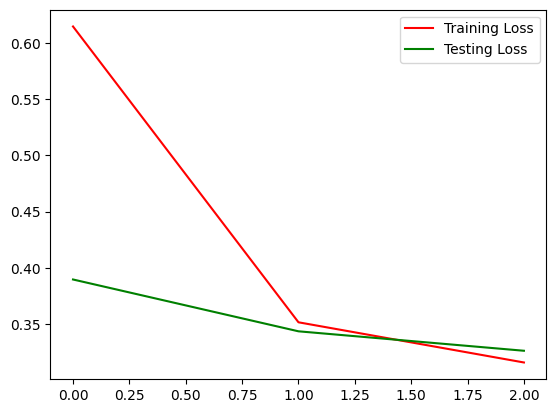

In [116]:
plt.plot(epoch_count,
         train_loss_list,c='red',label="Training Loss")
plt.plot(epoch_count,
         test_loss_list,c='green',label="Testing Loss")
plt.legend()

In [135]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import numpy as np

In [137]:
y_pred_list=[]
y_true_list=[]
model_2.eval()
with torch.inference_mode():
    for X,y in test_dataloader:
        y_logits=model_2(X)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_pred_list.append(y_pred.detach().numpy())
        y_true_list.append(y.detach().numpy())

In [138]:
y_true_list=np.concatenate(y_true_list)
y_true_list

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [139]:
y_pred_list=np.concatenate(y_pred_list)
y_pred_list

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

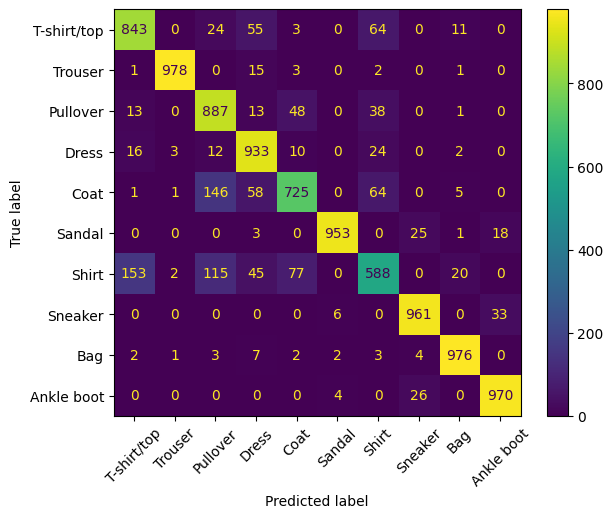

In [148]:
cm=confusion_matrix(y_true=y_true_list,y_pred=y_pred_list,labels=range(len(classes)))
disp=ConfusionMatrixDisplay(cm,display_labels=classes)
disp.plot()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
